In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn

Obtain the Dataset

In [2]:
import pandas as pd
import zipfile
import requests
from io import BytesIO

# Download the ZIP file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(response.content))

# List all files in the ZIP
print(zip_file.namelist())

# Extract and load the main dataset (diabetic_data.csv)
with zip_file.open('dataset_diabetes/diabetic_data.csv') as file:
    diabetes_data = pd.read_csv(file)

# Preview the dataset
print(diabetes_data.head())
print(diabetes_data.info())

['dataset_diabetes/diabetic_data.csv', 'dataset_diabetes/IDs_mapping.csv']
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-met

 Dataset Exploration

In [3]:
# Display the first few rows
print(diabetes_data.head())

# Check for null values
print(diabetes_data.isnull().sum())

# Summary of the dataset
print(diabetes_data.info())

# Check unique values for categorical columns
for col in diabetes_data.select_dtypes(include=['object']).columns:
    print(f"{col}: {diabetes_data[col].unique()[:10]}")

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

Data Cleaning

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the dataset (replace with the actual file path or URL if necessary)
# diabetes_data = pd.read_csv('your_dataset.csv')

# Step 1: Inspect dataset for issues
print(diabetes_data.info())

# Check unique values in important columns to identify anomalies
for column in ['race', 'gender', 'age', 'readmitted']:
    print(f"{column}: {diabetes_data[column].unique()}")

# Step 2: Check for missing values
missing_values = diabetes_data.isnull().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])

# Step 3: Replace "?" and other invalid entries with NaN
diabetes_data.replace("?", pd.NA, inplace=True)

# Step 4: Drop columns with excessive missing data or irrelevant content
columns_to_drop = ['weight', 'payer_code', 'medical_specialty']
existing_columns_to_drop = [col for col in columns_to_drop if col in diabetes_data.columns]
diabetes_data.drop(columns=existing_columns_to_drop, inplace=True)

# Step 5: Drop rows with missing values
diabetes_data.dropna(inplace=True)

# Step 6: Transform target variable 'readmitted' into binary
diabetes_data['readmitted'] = diabetes_data['readmitted'].apply(lambda x: 1 if x in ['<30', '>30'] else 0)

# Step 7: One-hot encode categorical columns
categorical_columns = ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed']
diabetes_data = pd.get_dummies(diabetes_data, columns=categorical_columns, drop_first=True)

# Step 8: Normalize numeric columns using MinMaxScaler
numerical_columns = diabetes_data.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler()
diabetes_data[numerical_columns] = scaler.fit_transform(diabetes_data[numerical_columns])

# Final check
print(diabetes_data.info())  # Check the final dataset structure
print(diabetes_data.head())  # Display a sample of the cleaned dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

Encoding Categorical Features

In [5]:
from sklearn.preprocessing import OneHotEncoder

# Updated categorical columns based on the dataset
categorical_columns = [
    'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
    'gender_Male', 'age_[20-30)', 'age_[30-40)', 'age_[40-50)',
    'age_[50-60)', 'age_[60-70)', 'age_[70-80)', 'age_[80-90)',
    'max_glu_serum_>300', 'max_glu_serum_Norm', 'A1Cresult_>8',
    'A1Cresult_Norm', 'change_No', 'diabetesMed_Yes'
]

# Create a transformer for OneHotEncoding (updated to use sparse_output=False)
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Apply OneHotEncoding to the categorical columns
X = diabetes_data.drop(columns=['readmitted'])  # Drop the target column
X_encoded = X.copy()

# Apply one-hot encoding
X_encoded[categorical_columns] = ohe.fit_transform(X[categorical_columns])

# Check the shape of the encoded data
print("Shape of the encoded data:", X_encoded.shape)

# Display the first few rows of the encoded data
X_encoded.head()

Shape of the encoded data: (289, 57)


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,age_[50-60),age_[60-70),age_[70-80),age_[80-90),max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_Norm,change_No,diabetesMed_Yes
162,0.000000,0.458042,1.0,0.166667,1.000000,0.307692,0.213333,0.166667,0.147059,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
460,0.003614,0.437689,1.0,0.000000,1.000000,0.692308,0.546667,0.166667,0.529412,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
593,0.005280,0.656147,1.0,0.000000,1.000000,0.076923,0.400000,0.000000,0.117647,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
696,0.006469,0.500282,1.0,0.416667,1.000000,0.769231,0.533333,0.166667,0.558824,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
771,0.008029,0.342231,1.0,0.000000,0.166667,1.000000,0.160000,0.000000,0.294118,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Scaling the Features

In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming 'diabetes_data' is your DataFrame, and 'X' is your feature set
# If it's not yet defined, you would need to do that based on the data

# Apply One-Hot Encoding (if needed)
categorical_columns = X.select_dtypes(include=['object']).columns
X_encoded = X.copy()

# Apply one-hot encoding to the categorical columns
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = ohe.fit_transform(X[categorical_columns])

# Convert the encoded features to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(categorical_columns))

# Drop original categorical columns and add the encoded features
X_encoded = X.drop(columns=categorical_columns)
X_encoded = pd.concat([X_encoded, encoded_df], axis=1)

# Now proceed with the scaling and splitting

# Separating the features and the target variable
y = diabetes_data['readmitted']

# Ensure that X_encoded and y have the same number of rows
X_encoded = X_encoded.iloc[:len(y), :]

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the shapes after scaling
print(X_train_scaled.shape, X_test_scaled.shape)


(231, 348) (58, 348)


Train ML model

Logistic Regression Baseline

In [8]:
from sklearn.impute import SimpleImputer
import numpy as np

# Check for missing values in the training and testing datasets
print("Missing values in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("Missing values in X_test_scaled:", np.isnan(X_test_scaled).sum())

# Impute missing values in the scaled data
imputer = SimpleImputer(strategy='mean')  # You can change strategy to 'median' or 'most_frequent'

# Apply the imputer to the scaled training and testing data
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

# Check again for missing values
print("Missing values in X_train_scaled after imputation:", np.isnan(X_train_scaled).sum())
print("Missing values in X_test_scaled after imputation:", np.isnan(X_test_scaled).sum())

# Now proceed with training the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Missing values in X_train_scaled: 72910
Missing values in X_test_scaled: 18386
Missing values in X_train_scaled after imputation: 0
Missing values in X_test_scaled after imputation: 0
Confusion Matrix:
[[10  9]
 [13 26]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.43      0.53      0.48        19
         1.0       0.74      0.67      0.70        39

    accuracy                           0.62        58
   macro avg       0.59      0.60      0.59        58
weighted avg       0.64      0.62      0.63        58


Accuracy Score:
0.6206896551724138


Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test_scaled)

# Evaluate the model
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Display the results
print("Confusion Matrix (Random Forest):")
print(conf_matrix_rf)

print("\nClassification Report (Random Forest):")
print(class_report_rf)

print("\nAccuracy Score (Random Forest):")
print(accuracy_rf)

Confusion Matrix (Random Forest):
[[12  7]
 [13 26]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

         0.0       0.48      0.63      0.55        19
         1.0       0.79      0.67      0.72        39

    accuracy                           0.66        58
   macro avg       0.63      0.65      0.63        58
weighted avg       0.69      0.66      0.66        58


Accuracy Score (Random Forest):
0.6551724137931034


Support Vector Machine (SVM) and
Gradient Boosting Classifier

In [10]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Model 1: Support Vector Machine (SVM)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

print("Confusion Matrix (SVM):")
print(confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report (SVM):")
print(classification_report(y_test, y_pred_svm))
print("\nAccuracy Score (SVM):")
print(accuracy_score(y_test, y_pred_svm))

# Model 2: Gradient Boosting Classifier
from xgboost import XGBClassifier

gb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)

print("\nConfusion Matrix (Gradient Boosting):")
print(confusion_matrix(y_test, y_pred_gb))
print("\nClassification Report (Gradient Boosting):")
print(classification_report(y_test, y_pred_gb))
print("\nAccuracy Score (Gradient Boosting):")
print(accuracy_score(y_test, y_pred_gb))

Confusion Matrix (SVM):
[[ 9 10]
 [ 8 31]]

Classification Report (SVM):
              precision    recall  f1-score   support

         0.0       0.53      0.47      0.50        19
         1.0       0.76      0.79      0.78        39

    accuracy                           0.69        58
   macro avg       0.64      0.63      0.64        58
weighted avg       0.68      0.69      0.68        58


Accuracy Score (SVM):
0.6896551724137931


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:13:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Confusion Matrix (Gradient Boosting):
[[10  9]
 [12 27]]

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

         0.0       0.45      0.53      0.49        19
         1.0       0.75      0.69      0.72        39

    accuracy                           0.64        58
   macro avg       0.60      0.61      0.60        58
weighted avg       0.65      0.64      0.64        58


Accuracy Score (Gradient Boosting):
0.6379310344827587


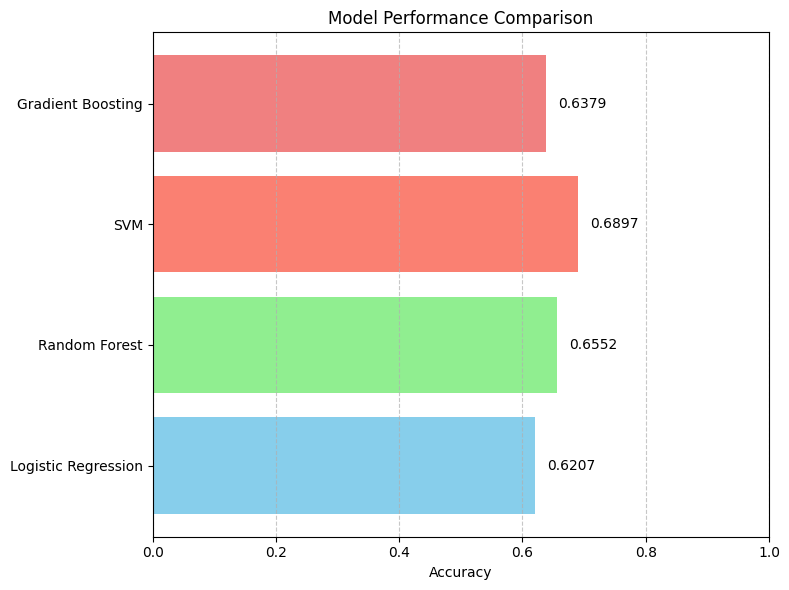

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and accuracy scores
models = ['Logistic Regression', 'Random Forest', 'SVM', 'Gradient Boosting']
accuracies = [0.6207, 0.6552, 0.6897, 0.6379]

# Create a bar chart to compare the accuracy of models
plt.figure(figsize=(8, 6))
plt.barh(models, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
plt.xlabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xlim([0, 1])
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the accuracy values on the bars
for index, value in enumerate(accuracies):
    plt.text(value + 0.02, index, f'{value:.4f}', va='center')

plt.tight_layout()
plt.show()

Hyperparameter Tuning

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the SVM model
svm_model = SVC(random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Type of kernel
    'gamma': ['scale', 'auto'],  # Kernel coefficient
}

# Perform grid search
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Use the best model to predict on the test set
best_svm_model = grid_search.best_estimator_
y_pred_best = best_svm_model.predict(X_test_scaled)

# Evaluate the tuned model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Confusion Matrix
print("Confusion Matrix (Tuned SVM):")
print(confusion_matrix(y_test, y_pred_best))

# Classification Report
print("\nClassification Report (Tuned SVM):")
print(classification_report(y_test, y_pred_best))

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred_best)
print(f"Accuracy Score (Tuned SVM): {accuracy}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.6491211840888067
Confusion Matrix (Tuned SVM):
[[ 9 10]
 [ 8 31]]

Classification Report (Tuned SVM):
              precision    recall  f1-score   support

         0.0       0.53      0.47      0.50        19
         1.0       0.76      0.79      0.78        39

    accuracy                           0.69        58
   macro avg       0.64      0.63      0.64        58
weighted avg       0.68      0.69      0.68        58

Accuracy Score (Tuned SVM): 0.6896551724137931


Model Performance Reporting (Visualization)

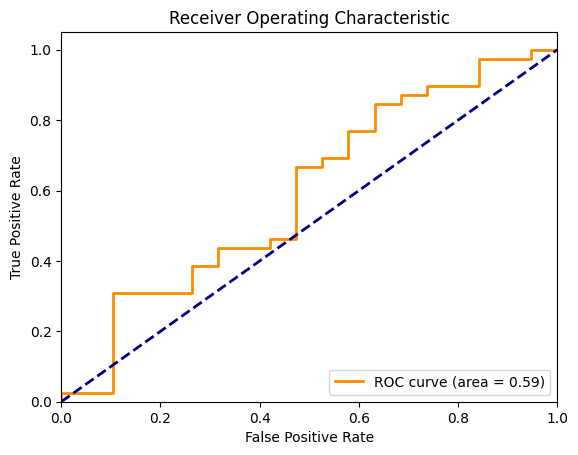

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Deploying the Model

In [ ]:
import joblib

# Save the model
joblib.dump(model, 'diabetes_model.pkl')

# Load the model
loaded_model = joblib.load('diabetes_model.pkl')